In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from epf.util import load_and_concat_data
from epf.config import FeatureConfig

fc = FeatureConfig()

2025-05-25 12:15:16.856 | INFO     | epf.config:<module>:19 - PROJ_ROOT path is: C:\Users\valen\PycharmProjects\epf
2025-05-25 12:15:16.856 | INFO     | epf.config:create_dir:15 - DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data
2025-05-25 12:15:16.857 | INFO     | epf.config:create_dir:15 - RAW_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/raw
2025-05-25 12:15:16.857 | INFO     | epf.config:create_dir:15 - INTERIM_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/interim
2025-05-25 12:15:16.858 | INFO     | epf.config:create_dir:15 - PROCESSED_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/processed
2025-05-25 12:15:16.858 | INFO     | epf.config:create_dir:15 - TRAIN_DATA_DIR path is: C:/Users/valen/PycharmProjects/epf/data/processed/train_data
2025-05-25 12:15:16.859 | INFO     | epf.config:create_dir:15 - MODELS_DIR path is: C:/Users/valen/PycharmProjects/epf/models
2025-05-25 12:15:16.859 | INFO     | epf.config:create_dir:15 - PREDICTIONS_D

In [2]:
file_paths = fc.INPUT_PATHS
col_names = fc.COL_NAMES
to_resample = fc.TO_RESAMPLE

COLORS = {
    "blue": "#3a609c",
    "blue_grey": "#69a0cb",
    "light_blue": "#afe1f5",
    "dark_green": "#345c0e",
    "olive": "#74953d",
    "green": "#c0d159",
    "gold": "#ffd700",
    "orange": "#ffb14e",
    "light_orange": "#fa8775",
    "magenta": "#840853",
    "purple": "#ba55aa",
    "light_purple": "#d1a7ef"
}

In [4]:
df = []
freq = {}
dates = {}
feature_names = {
    "de_prices" : "Prices DE_LU",
    "de_load" : "Load DE",
    "de_solar_gen" : "Solar DE",
    "de_wind_gen_offshore" : "Wind generation offshore DE",
    "de_wind_gen_onshore" : "Wind generation onshore DE",
    "de_gas_gen" : "Gas generation DE",
    "de_lignite_gen" : "Lignite generation DE",
    "de_hard_coal_gen" : "Hard coal generation DE",
    "ch_load" : "Load CH",
    "dk_load" : "Load DK",
    "fr_load" : "Load FR",
    "ch_prices" : "Prices CH",
    "dk1_prices" : "Prices DK1",
    "dk2_prices" : "Prices DK2",
    "fr_prices" : "Prices FR",
}

for file_path in file_paths.values():
    col_name = [k for k, v in file_paths.items() if v == file_path]
    data = load_and_concat_data(file_path, col_name[0])

    freq.update({col_name[0] : pd.infer_freq(data.index)})
    dates.update({col_name[0] : {"start" : data.index[0], "end" : data.index[-1]}})

    if data.columns.values[0] in to_resample:
        resample_freq: int = to_resample.get(data.columns.values[0])
        data = data[::resample_freq]

    df.append(data)

df = pd.concat(df, axis=1)

## Statistical Summary

In [85]:
summary = df.describe().transpose()
# match summary index with freq keys to accurately retrieve frequency values
summary["freq"] = summary.index.map(freq)
# get a start and end date for each feature, reformatting the index to a well readable date time format
summary["start"] = summary.index.map(lambda x: dates[x]["start"])
summary["end"] = summary.index.map(lambda x: dates[x]["end"])
summary["start"] = summary["start"].dt.strftime("%d.%m.%Y %H:%M")
summary["end"] = summary["end"].dt.strftime("%d.%m.%Y %H:%M")

summary.index = summary.index.map(feature_names)

summary

,count,mean,std,min,25%,50%,75%,max,freq,start,end
Prices DE_LU,17544.0,87.364521,57.217911,-500.00,62.8675,88.850,112.5000,2325.83,h,31.12.2022 23:00,31.12.2024 22:00
Load DE,70176.0,52660.885957,9146.020138,27932.90,45133.8000,52620.950,59759.2250,75766.70,15min,31.12.2022 23:00,31.12.2024 22:45
Solar DE,70176.0,6775.300281,10467.557921,0.80,3.2000,111.500,10712.4500,47065.80,15min,31.12.2022 23:00,31.12.2024 22:45
Wind generation offshore DE,70176.0,2803.653534,1863.546252,0.00,1123.5750,2608.650,4331.3500,7640.30,15min,31.12.2022 23:00,31.12.2024 22:45
Wind generation onshore DE,70176.0,13186.427301,10299.038422,42.40,4916.8250,10353.250,19277.9000,48157.90,15min,31.12.2022 23:00,31.12.2024 22:45
Gas generation DE,70176.0,6230.694668,3204.983150,1586.30,3681.8250,5572.150,7992.3000,19168.90,15min,31.12.2022 23:00,31.12.2024 22:45
Lignite generation DE,70176.0,8483.260824,3538.360315,2461.60,5346.1250,8347.950,11190.3000,17200.80,15min,31.12.2022 23:00,31.12.2024 22:45
Hard coal generation DE,70176.0,3823.886427,2855.113169,307.40,1793.2000,2931.800,5123.2250,15256.20,15min,31.12.2022 23:00,31.12.2024 22:45
Load CH,17544.0,6879.845651,1053.874647,2742.60,6185.0500,6898.400,7588.7250,10437.10,h,31.12.2022 23:00,31.12.2024 22:00
Load DK,17544.0,4061.867909,718.324942,2371.20,3526.4750,4047.250,4587.7250,9069.60,h,31.12.2022 23:00,31.12.2024 22:00


## Seasonal Analysis

In [5]:
# plot daily seasonality
df['hour'] = df.index.hour
df['day'] = df.index.day
df['day_string'] = [x.strftime('%a') for x in df.index]
df['month'] = df.index.month
df['month_string'] = [x.strftime('%b') for x in df.index]
df['year'] = df.index.year
df['week'] = [x.strftime('%W') for x in df.index]
df['season'] = [
    'Winter' if x.month in [12, 1, 2] else
    'Spring' if x.month in [3, 4, 5] else
    'Summer' if x.month in [6, 7, 8] else
    'Autumn' for x in df.index
]
de_holidays = holidays.country_holidays('DE', years=[2023,2024])
# set holiday to 1 if it is a holiday else 0
df['holiday'] = df.index.to_series().apply(lambda x: "Holiday" if x in de_holidays else "No holiday")

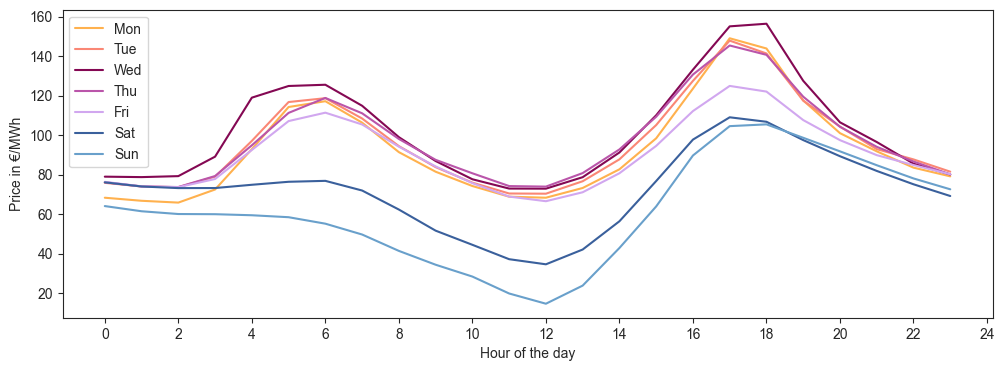

In [6]:
day_colors = {
    'Mon': COLORS['orange'],
    'Tue': COLORS['light_orange'],
    'Wed': COLORS['magenta'],
    'Thu': COLORS['purple'],
    'Fri': COLORS['light_purple'],
    'Sat': COLORS['blue'],
    'Sun': COLORS['blue_grey'],
}
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

df_plot_daily = df[['hour', 'de_prices', 'day_string']].groupby(['hour', 'day_string']).mean()[['de_prices']].reset_index()

sns.set_style("ticks")

plt.figure(figsize=(12, 4))
sns.lineplot(data = df_plot_daily, x='hour', y='de_prices', hue='day_string', hue_order=day_order, palette=day_colors, legend=True)
plt.locator_params(axis='x', nbins=24)
plt.legend(loc='upper left')
plt.xlabel("Hour of the day")
plt.ylabel("Price in €/MWh")

#plt.title("Average prices per hour of the day in DE_LU bidding zone")

plt.savefig("../reports/figures/avg_hourly_prices.svg", dpi=300, bbox_inches='tight')

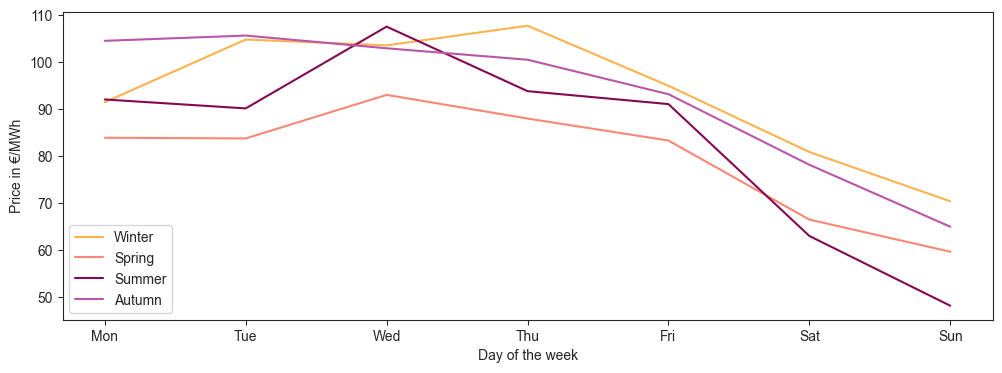

In [7]:
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

month_colors = {
    'Winter': COLORS['orange'],
    'Spring': COLORS['light_orange'],
    'Summer': COLORS['magenta'],
    'Autumn': COLORS['purple'],
}

df_plot_monthly = df[['de_prices', 'day_string', 'season']].groupby(['day_string', 'season']).mean()[['de_prices']].reset_index()
df_plot_monthly['day_string'] = pd.Categorical(df_plot_monthly['day_string'], categories=day_order, ordered=True)

sns.set_style("ticks")

plt.figure(figsize=(12, 4))
sns.lineplot(data = df_plot_monthly, x='day_string', y='de_prices', hue='season', hue_order=season_order, palette=month_colors, legend=True)
plt.legend(loc='lower left')
plt.xlabel("Day of the week")
plt.ylabel("Price in €/MWh")

#plt.title("Average prices per day of the week compared to season in DE_LU bidding zone")

plt.savefig("../reports/figures/avg_daily_prices.svg", dpi=300, bbox_inches='tight')

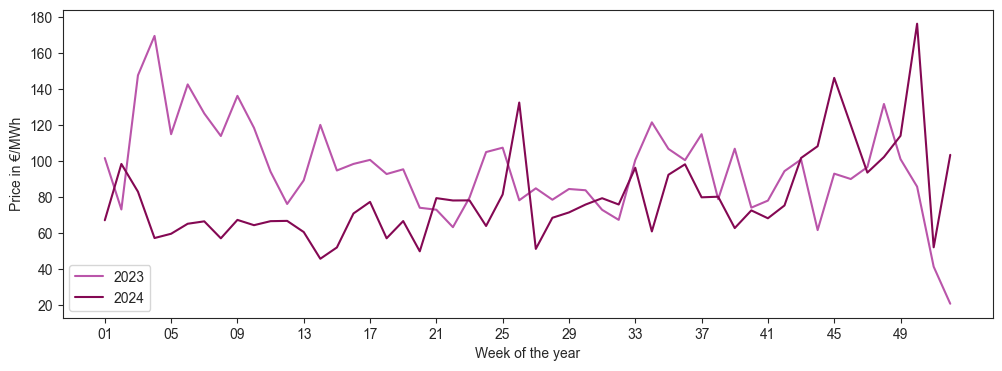

In [8]:
df_plot_yearly = df[['de_prices', 'week', 'year']].groupby(['week', 'year']).mean()[['de_prices']].reset_index()
i = df_plot_yearly[(df_plot_yearly.year == 2022)].index
df_plot_yearly.drop(i, inplace=True)
df_plot_yearly.drop(0, inplace=True)
df_plot_yearly.drop(106, inplace=True)

weeks = df_plot_yearly['week'].unique()

palette = {
    2023: COLORS["purple"],
    2024: COLORS["magenta"],
}

sns.set_style("ticks")

plt.figure(figsize=(12, 4))
sns.lineplot(data = df_plot_yearly, x='week', y='de_prices', hue='year', palette=palette, legend=True)
plt.xticks(ticks=weeks[::4], labels=weeks[::4])
plt.legend(loc='lower left')
plt.ylabel("Price in €/MWh")
plt.xlabel("Week of the year")

#plt.title("Average prices per week in DE_LU bidding zone")

plt.savefig("../reports/figures/avg_weekly_prices.svg", dpi=300, bbox_inches='tight')

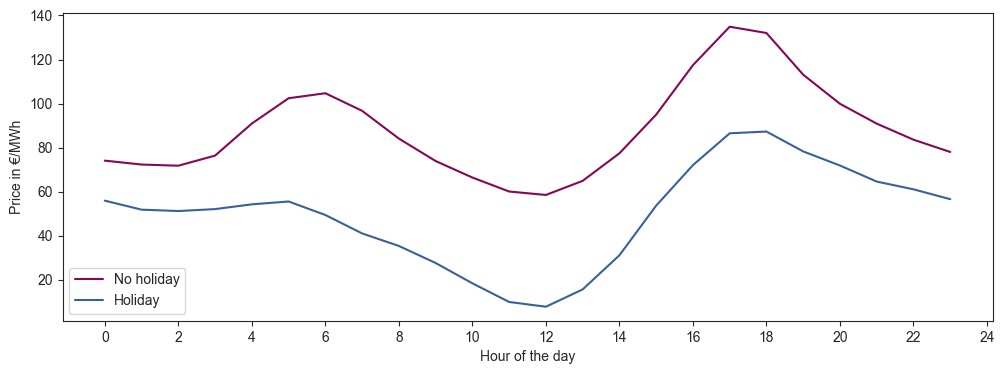

In [17]:
df_plot_holiday = df[['de_prices', 'holiday', 'hour']].groupby(['holiday', 'hour']).mean()[['de_prices']].reset_index()

palette = {
    "Holiday": COLORS["blue"],
    "No holiday": COLORS["magenta"],
}

hue_order = ['No holiday', 'Holiday']

sns.set_style("ticks")

plt.figure(figsize=(12, 4))
sns.lineplot(data = df_plot_holiday, x='hour', y='de_prices', hue='holiday', hue_order=hue_order, palette=palette, legend=True)
plt.locator_params(axis='x', nbins=24)
plt.legend(loc='lower left')
plt.xlabel("Hour of the day")
plt.ylabel("Price in €/MWh")

#plt.title("Average hourly prices in DE_LU bidding zone")

plt.savefig("../reports/figures/avg_holiday_prices.pdf", dpi=300, bbox_inches='tight')

## Correlation Analysis

First check for stationarity to find out whether there is within series dependence see [[6]](../references/refs.md)
Also see [[7]](https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series) for a detailled breakdown

In [10]:
corr = df[['de_prices', 'de_load', 'de_solar_gen', 'de_wind_gen_offshore', 'de_wind_gen_onshore', 'de_gas_gen', 'de_lignite_gen',
 'de_hard_coal_gen', 'ch_load', 'dk_load', 'fr_load', 'ch_prices', 'dk1_prices', 'dk2_prices', 'fr_prices']]

In [11]:
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection

# Authors: Mr. T (Jan 2021) and PatrickT (Aug 2022)
# at https://stackoverflow.com/questions/65870368/how-to-change-color-in-statsmodels-plot-acf-function
def plot_acf_colors(ax, markercolor, linecolor, facecolor, barcolor, linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    for item in ax.collections:
        # change the color of the confidence interval
        if isinstance(item, PolyCollection):
            item.set_facecolor((facecolor, 0.0))
        # change the color of the vertical lines
        if isinstance(item, LineCollection):
            item.set_color((barcolor, 0.1))
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

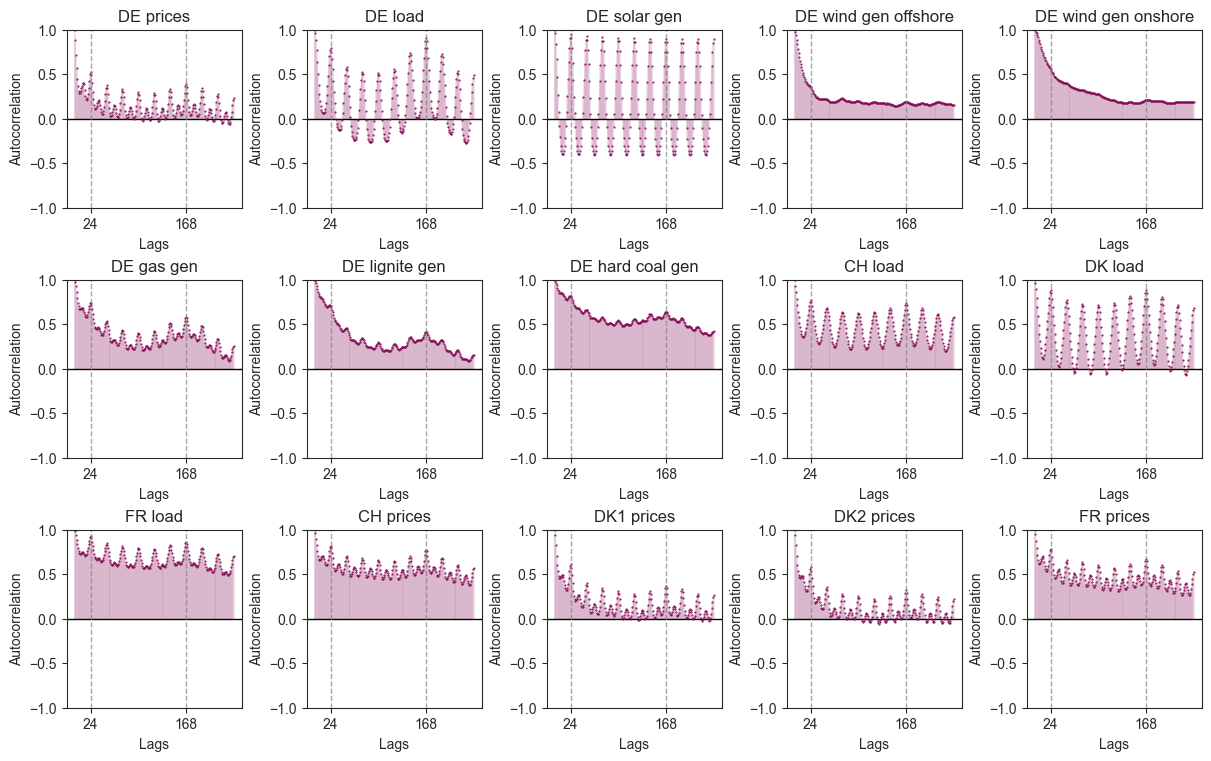

In [12]:
sns.set_style("ticks")

columns = corr.columns

n_cols = 5
n_rows = (len(columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows), constrained_layout=True)

for i, col in enumerate(columns):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx]
    title = col.split('_')[0].upper() + " " + " ".join(col.split('_')[1:])
    plot_acf(corr[col], lags=240, ax=ax, title=title, markersize=1, marker='.', alpha=None)
    ax = plot_acf_colors(ax, markercolor=COLORS["magenta"], linecolor="black", facecolor=COLORS["magenta"], barcolor=COLORS["magenta"])

    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticks([24, 168])
    ax.set_ylabel("Autocorrelation")
    ax.set_xlabel("Lags")

    ax.axvline(x=24, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=168, color='gray', linestyle='--', linewidth=1, alpha=0.7)

for j in range(i + 1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    fig.delaxes(axes[row, col_idx])

plt.savefig("../reports/figures/acf_long.svg", dpi=300, bbox_inches='tight')
plt.show()

All timeseries are non-stationary so we need do difference them

In [13]:
from statsmodels.tsa.statespace.tools import diff

corr_diff = pd.DataFrame(diff(corr, k_diff=2, k_seasonal_diff=1, seasonal_periods=24))

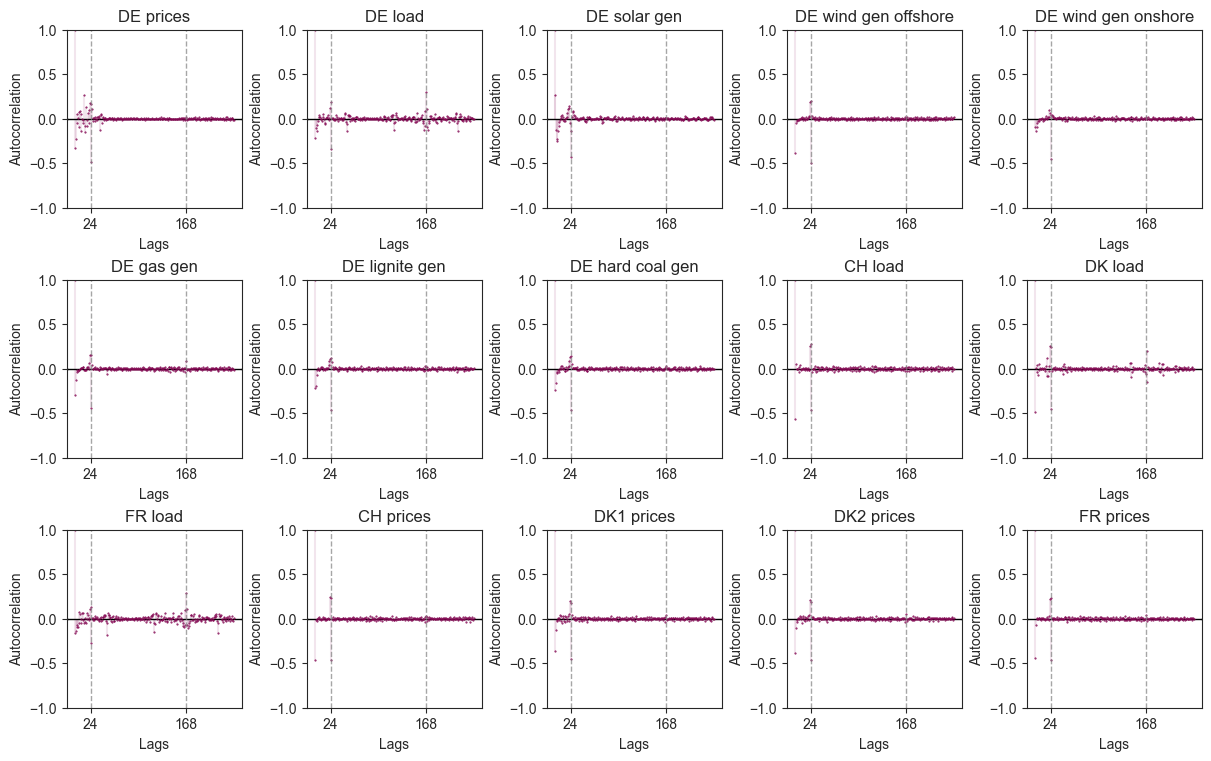

In [14]:
sns.set_style("ticks")

columns = corr_diff.columns

n_cols = 5
n_rows = (len(columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows), constrained_layout=True)

for i, col in enumerate(columns):
    row, col_idx = divmod(i, n_cols)
    ax = axes[row, col_idx]
    title = col.split('_')[0].upper() + " " + " ".join(col.split('_')[1:])
    plot_acf(corr_diff[col], lags=240, ax=ax, title=title, markersize=1, marker='.', alpha=None)
    ax = plot_acf_colors(ax, markercolor=COLORS["magenta"], linecolor="black", facecolor=COLORS["magenta"], barcolor=COLORS["magenta"])

    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticks([24, 168])
    ax.set_ylabel("Autocorrelation")
    ax.set_xlabel("Lags")

    ax.axvline(x=24, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(x=168, color='gray', linestyle='--', linewidth=1, alpha=0.7)

for j in range(i + 1, n_rows * n_cols):
    row, col_idx = divmod(j, n_cols)
    fig.delaxes(axes[row, col_idx])

plt.savefig("../reports/figures/acf_diff.svg", dpi=300, bbox_inches='tight')
plt.show()

since price timeseries are now linear and non dependent, pearson correlation can be done

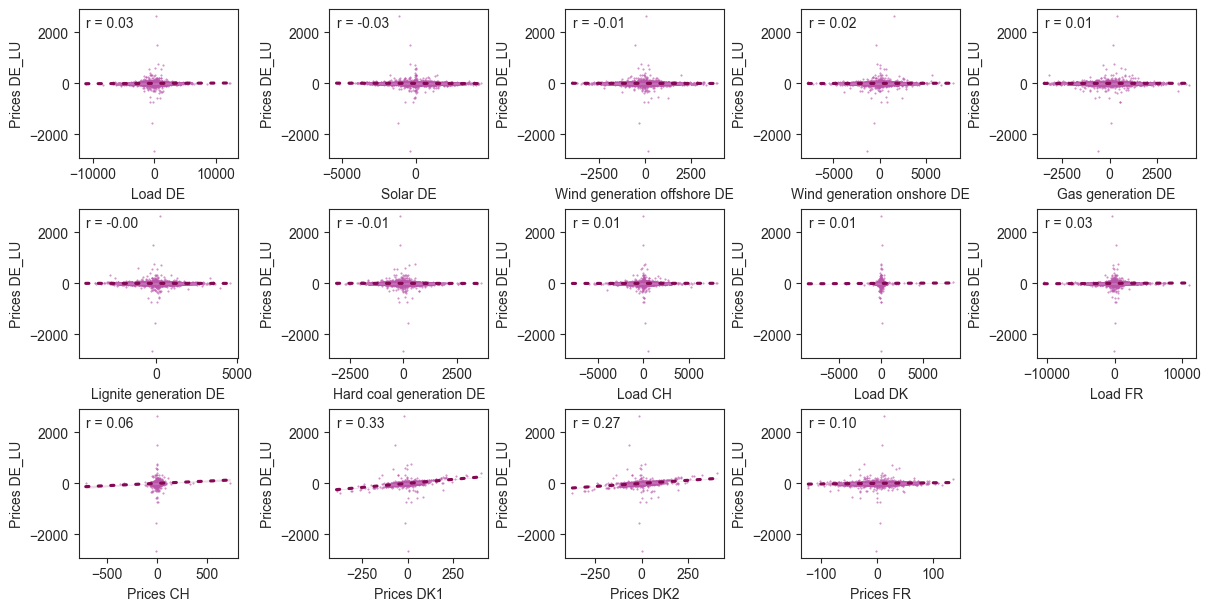

In [15]:
df_corr = corr_diff.corr(method="pearson")

features = ['de_load', 'de_solar_gen', 'de_wind_gen_offshore', 'de_wind_gen_onshore',
            'de_gas_gen', 'de_lignite_gen', 'de_hard_coal_gen', 'ch_load',
            'dk_load', 'fr_load', 'ch_prices', 'dk1_prices', 'dk2_prices', 'fr_prices']

sns.set_style("ticks")

n_cols = 5
n_rows = (len(features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows), constrained_layout=True)

for i, feature in enumerate(features):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]

    corr_coeff = df_corr.loc['de_prices', feature]

    sns.regplot(data=corr_diff, x=feature, y='de_prices', ax=ax, marker='.',
                scatter_kws={'color': COLORS['purple'], 'alpha': 0.7, 's': 1},
                line_kws={'color': COLORS['magenta'], 'dashes': [1,3], 'dash_capstyle': 'round'})
    ax.set_xlabel(feature_names[feature])
    ax.set_ylabel('Prices DE_LU')

    ax.annotate(f'r = {corr_coeff:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, ha='left', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    fig.delaxes(axes[row, col])

plt.savefig("../reports/figures/correlation_point_clouds.svg", dpi=300, bbox_inches='tight')
plt.show()

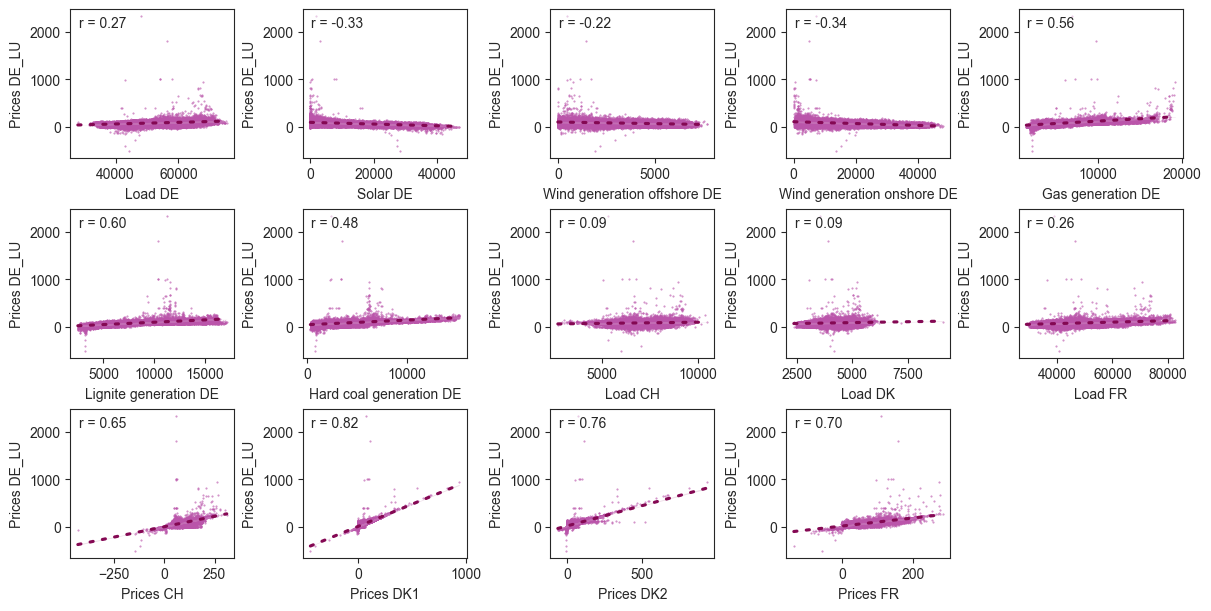

In [16]:
df_corr_without_diff = corr.corr(method="pearson")

features = ['de_load', 'de_solar_gen', 'de_wind_gen_offshore', 'de_wind_gen_onshore',
            'de_gas_gen', 'de_lignite_gen', 'de_hard_coal_gen', 'ch_load',
            'dk_load', 'fr_load', 'ch_prices', 'dk1_prices', 'dk2_prices', 'fr_prices']

sns.set_style("ticks")

n_cols = 5
n_rows = (len(features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows), constrained_layout=True)

for i, feature in enumerate(features):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]

    corr_coeff = df_corr_without_diff.loc['de_prices', feature]

    sns.regplot(data=corr, x=feature, y='de_prices', ax=ax, marker='.',
                scatter_kws={'color': COLORS['purple'], 'alpha': 0.7, 's': 1},
                line_kws={'color': COLORS['magenta'], 'dashes': [1,3], 'dash_capstyle': 'round'})
    ax.set_xlabel(feature_names[feature])
    ax.set_ylabel('Prices DE_LU')

    ax.annotate(f'r = {corr_coeff:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=10, ha='left', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    fig.delaxes(axes[row, col])

plt.savefig("../reports/figures/correlation_without_differencing_point_clouds.svg", dpi=300, bbox_inches='tight')
plt.show()

correlation analysis with respect to seasons